In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Define the connection parameters
host = 'localhost'
dbname = 'StarsGalaxiesQuasars'
user = 'postgres'
password = '121792'
port = '5432'

# Create the connection string
connection = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create a connection engine using SQLAlchemy
engine = create_engine(connection)

In [3]:
# Write a SQL query to join the observation and classification tables
join_query = """
SELECT o.*, c.class
FROM observation o
JOIN classification c ON o.classid = c.classid;
"""

In [4]:
# Load the data into a Pandas DataFrame
database_df = pd.read_sql(join_query, engine)

In [5]:
# Check DataFrame
database_df.head()

,observationid,classid,objid,ra,dec,u,g,r,i,z,redshift,run,rerun,camcol,field,specobjid,plate,mjd,fiberid,class
0,1,1,1237650000000000000,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752.0,301,4,267,3.722360e+18,-8.96e-06,3306,54922,491,STAR
1,2,1,1237650000000000000,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752.0,301,4,267,3.638140e+17,-5.49e-05,323,51615,541,STAR
2,3,2,1237650000000000000,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752.0,301,4,268,3.232740e+17,0.1231112,287,52023,513,GALAXY
3,4,1,1237650000000000000,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752.0,301,4,269,3.722370e+18,-0.000110616,3306,54922,510,STAR
4,5,1,1237650000000000000,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752.0,301,4,269,3.722370e+18,0.000590357,3306,54922,512,STAR


C:\Users\Ian O'Connor\AppData\Local\Temp\ipykernel_9700\3098073525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=database_df, x='class', palette='viridis')


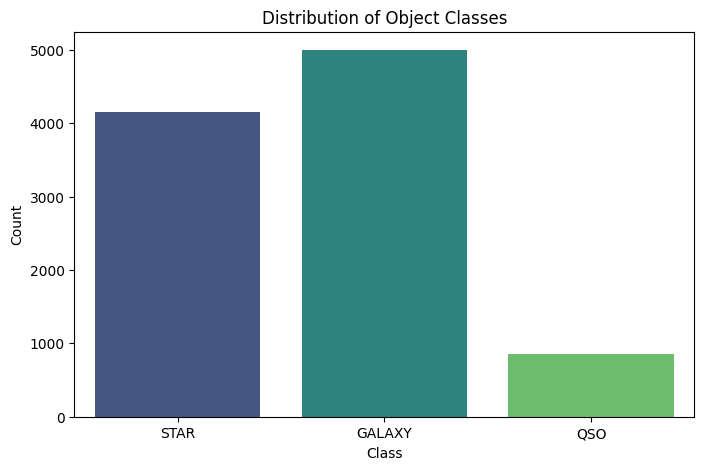

In [6]:
# Count plot of different classes
plt.figure(figsize=(8, 5))
sns.countplot(data=database_df, x='class', palette='viridis')
plt.title("Distribution of Object Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

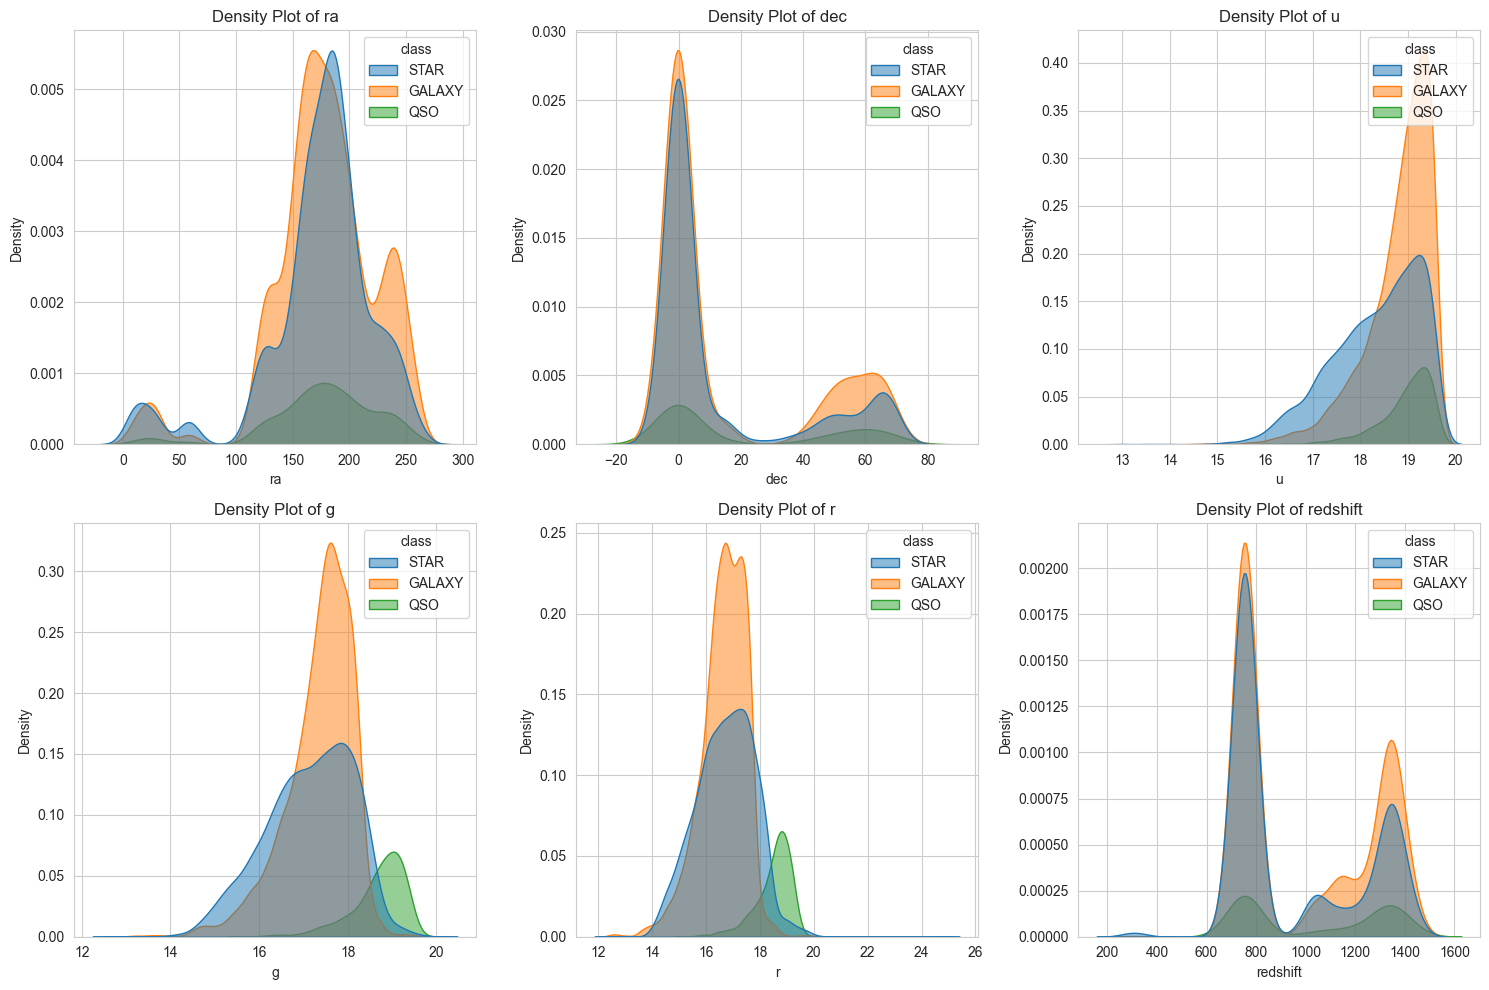

In [7]:
# Set plot style
sns.set_style("whitegrid")

# Density plots for numerical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['ra', 'dec', 'u', 'g', 'r', 'redshift']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.kdeplot(data=database_df, x=feature, hue='class', fill=True, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title(f"Density Plot of {feature}")

plt.tight_layout()
plt.show()

In [8]:
# Drop non-numeric columns except 'class'
ml = database_df.drop(columns=['observationid', 'classid', 'objid', 'specobjid', 'run', 'rerun', 'camcol', 'field', 'fiberid', 'plate', 'mjd'])

In [9]:
# Encode categorical target variable
le = LabelEncoder()
ml['class'] = le.fit_transform(ml['class'])

In [10]:
# Separate the data into labels and features
y = ml['class']
X = ml.drop(columns=['class'])

In [11]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
# Initialize StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [13]:
# Initialize the model
svm_model = SGDClassifier(loss='hinge', random_state=100, max_iter=1, tol=None)
n_epochs = 100

In [14]:
# Define class labels outside the loop
classes = np.unique(y)

print("\nTraining SVM with SGD:")
for epoch in tqdm(range(n_epochs), desc="Epoch Progress"):
    svm_model.partial_fit(X_train, y_train, classes=classes)


Training SVM with SGD:


Epoch Progress: 100%|██████████| 100/100 [00:00<00:00, 180.90it/s]


In [15]:
# Make predictions
y_pred = svm_model.predict(X_test)

In [16]:
# Evaluate the SVM model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.416

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       999
           1       0.00      0.00      0.00       169
           2       0.42      1.00      0.59       832

    accuracy                           0.42      2000
   macro avg       0.14      0.33      0.20      2000
weighted avg       0.17      0.42      0.24      2000



c:\ProgramData\Anaconda\envs\dev_2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda\envs\dev_2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda\envs\dev_2\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


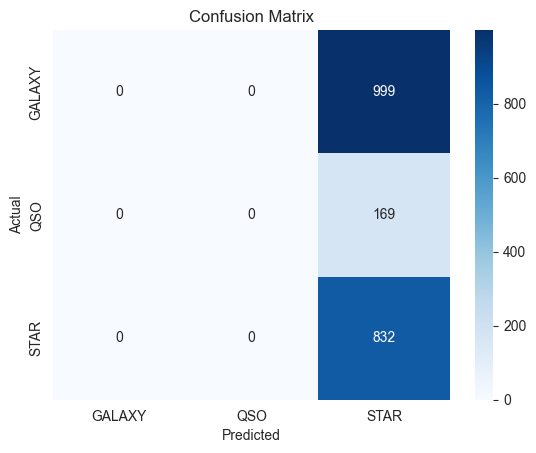

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

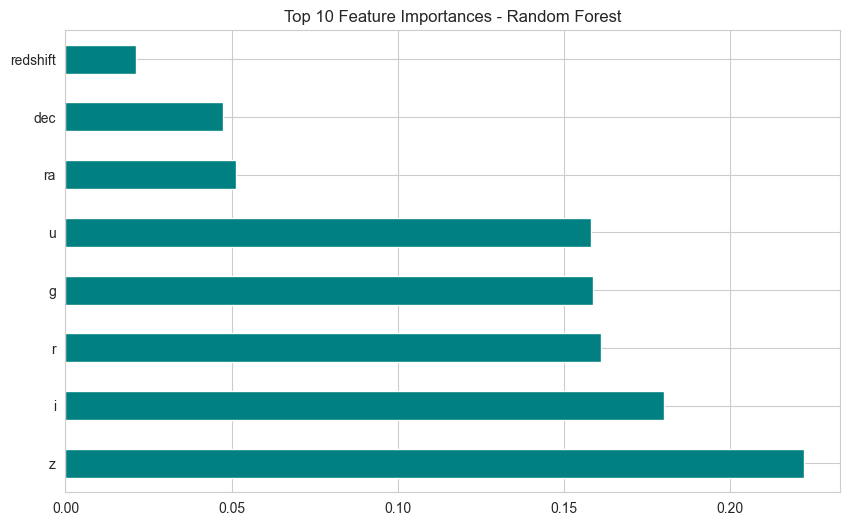

In [18]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature Importance Visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()

In [25]:
# Define the Hyperparameter Tuning grid for SVM
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
svc = SVC()

In [26]:
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, param_grid, n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, verbose=1, random_state=634)

def fit_with_progress_bar(random_search, X_train, y_train):
    with tqdm(total=random_search.n_iter, desc="Progress", unit="trial") as pbar:
        best_score = -np.inf
        best_params = None
        
        params = random_search.param_distributions
        for _ in range(random_search.n_iter):
            random_params = {key: np.random.choice(val) if isinstance(val, list) else val for key, val in params.items()}
            svc.set_params(**random_params)
            
            cv = StratifiedKFold(n_splits=random_search.cv, shuffle=True, random_state=1)
            cv_scores = [svc.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]).score(X_train.iloc[test_idx], y_train.iloc[test_idx]) for train_idx, test_idx in cv.split(X_train, y_train)]
            
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = random_params
            
            pbar.update(1)
        
        return best_params, best_score

In [27]:
best_params, best_score = fit_with_progress_bar(random_search, X_train, y_train)
print("\nBest SVM Parameters:", best_params)
print("\nBest Score:", best_score)

Progress: 100%|██████████| 4/4 [00:46<00:00, 11.73s/trial]


Best SVM Parameters: {'C': 1.0, 'kernel': 'linear'}

Best Score: 0.9417499200446907


In [28]:
# Train with linear kernel model
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [29]:
# Predictions
y_pred_linear = svm_linear.predict(X_test)

In [30]:
# Evaluate the linear Kernel Model
print("Linear Kernel Classification Report:")
print(classification_report(y_test, y_pred_linear))
print("Accuracy (linear Kernel):", accuracy_score(y_test, y_pred_linear))

Linear Kernel Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       999
           1       0.91      0.86      0.88       169
           2       0.91      0.97      0.94       832

    accuracy                           0.94      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy (linear Kernel): 0.9385


In [31]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [32]:
svm_model_pca = SGDClassifier(loss='hinge', max_iter=10000, tol=1e-3, verbose=1, random_state=100)
svm_model_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_model_pca.predict(X_test_pca)

-- Epoch 1
Norm: 316.86, NNZs: 2, Bias: 348.139465, T: 8000, Avg. loss: 52764.395312
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 66.30, NNZs: 2, Bias: 349.242103, T: 16000, Avg. loss: 15502.467981
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 134.06, NNZs: 2, Bias: 365.485516, T: 24000, Avg. loss: 9431.059128
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 80.86, NNZs: 2, Bias: 369.111474, T: 32000, Avg. loss: 6732.329269
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 64.31, NNZs: 2, Bias: 357.866219, T: 40000, Avg. loss: 5203.915028
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 71.11, NNZs: 2, Bias: 318.509283, T: 48000, Avg. loss: 4254.993530
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 38.25, NNZs: 2, Bias: 317.773037, T: 56000, Avg. loss: 3757.480592
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 12.27, NNZs: 2, Bias: 302.349720, T: 64000, Avg. loss: 3128.005405
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 33.09, NNZs: 2, Bias: 287.96

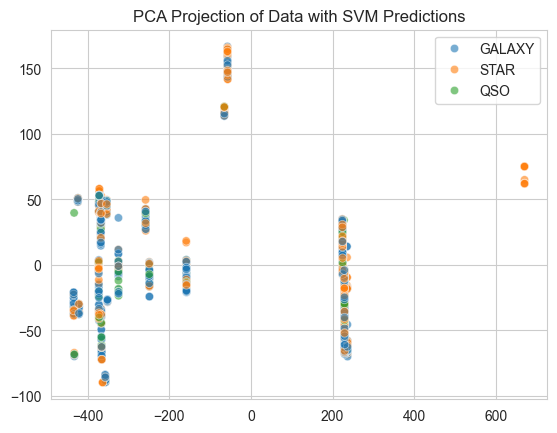

In [33]:
hue_labels = le.inverse_transform(y_test) if hasattr(le, "classes_") else y_test
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=hue_labels, alpha=0.6)
plt.title("PCA Projection of Data with SVM Predictions")
plt.show()